<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/diffusion_model_training_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

In [ ]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

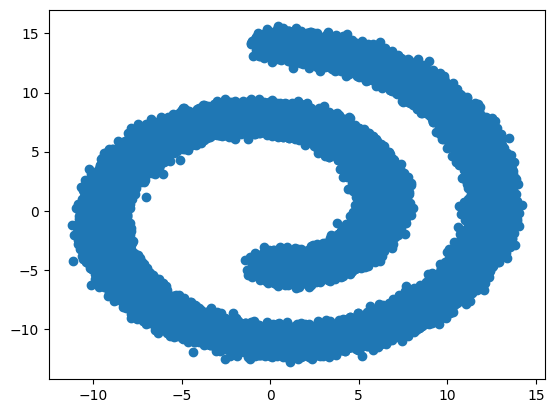

In [ ]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and cmpute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$. A perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [ ]:
import math
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

def train(model, train_loader, optimizer, scheduler):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, total=len(train_loader)):
        batch = [b.cuda() for b in batch]
        loss = model.loss(*batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    return train_losses

@torch.no_grad()
def eval_loss(model, data_loader):
    model.eval()
    total_loss, total = 0, 0
    for batch in data_loader:
        batch = [b.cuda() for b in batch]
        loss = model.loss(*batch)
        total_loss += loss.item() * batch[0].shape[0]
        total += batch[0].shape[0]
    avg_loss = total_loss / total
    return avg_loss
# get_lr is designed to compute a learning rate multiplier based on the current training step.
# It typically serves in a learning rate schedule where you might want to warm up the learning rate
# at the beginning and then apply a decay (such as cosine decay) as training progresses.
# This multiplier is then usually multiplied by a base learning rate to get the actual learning rate used at each step
def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        mul = (step + 1) / warmup_steps
        return mul
    else:
        #Post-Warmup Phase
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    optimizer = optim.Adam(model.parameters(), lr)
    total_steps = epochs * len(train_loader)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in tqdm(list(range(epochs))):
        train_loss = train(model, train_loader, optimizer, scheduler)
        train_losses.extend(train_loss)
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f"Epoch {epoch}, Test loss {test_loss:.4f}, Train loss {np.mean(train_loss):.4f}")

    return np.array(train_losses), np.array(test_losses)

# a diffusion-based model framework, a data sample (e.g., an image) is gradually noised and then denoised by a neural network (here, self.model).
# The goal is to train the model to predict the noise component so that, during generation, you can gradually remove noise and obtain a clean sample.
class Diffusion:
    def __init__(self, model, data_shape, encode_fn=None, decode_fn=None):
        self.model = model
        self.data_shape = data_shape
        self.encode_fn = encode_fn
        self.decode_fn = decode_fn

    def _get_alpha_sigma(self, t):
        return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

    def _expand(self, t):
        for _ in range(len(self.data_shape)):
            t = t[..., None]
        return t

    def _noise(self, x, eps=None, t=None):
        if t is None:
            t = torch.rand(x.shape[0], dtype=torch.float32, device=x.device)
        if eps is None:
            eps = torch.randn_like(x)
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        x_t = alpha_t * x + sigma_t * eps
        return x_t, eps, t

    def _x_hat(self, x_t, eps_hat, t):
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        return (x_t - sigma_t * eps_hat) / alpha_t
    # The loss method computes the mean squared error between the noise predicted by the model and the actual noise.
    # This is used to train the model so that it learns to remove noise accurately.
    def loss(self, x, y=None):
        if self.encode_fn is not None:
            x = self.encode_fn(x)
        x_t, eps, t = self._noise(x)
        if y is not None:
            eps_hat = self.model(x_t, y, t)
        else:
            eps_hat = self.model(x_t, t)
        return torch.mean((eps_hat - eps) ** 2)

    @torch.no_grad()
    def sample(self, n, num_steps, clip_denoised=False, model_fn=None, cfg_val=None):
        model_fn = model_fn or self.model

        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1, dtype=np.float32)
        x = torch.randn(n, *self.data_shape, dtype=torch.float32).cuda()
        for i in range(num_steps):
            t_cur = torch.full((n,), ts[i], dtype=torch.float32).cuda()
            t_next = torch.full((n,), ts[i + 1], dtype=torch.float32).cuda()

            alpha_cur, sigma_cur = self._get_alpha_sigma(self._expand(t_cur))
            alpha_next, sigma_next = self._get_alpha_sigma(self._expand(t_next))
            ddim_sigma = (sigma_next / sigma_cur) * torch.sqrt(1 - alpha_cur ** 2 / alpha_next ** 2)

            if cfg_val is None:
                eps_hat = model_fn(x, t_cur)
            else:
                eps_hat_cond = model_fn(x, t_cur)
                eps_hat_uncond = model_fn(x, t_cur, dropout_cond=True)
                eps_hat = eps_hat_uncond + cfg_val * (eps_hat_cond - eps_hat_uncond)

            x_hat = self._x_hat(x, eps_hat, t_cur)
            if clip_denoised:
                x_hat = torch.clamp(x_hat, -1, 1)
            x = alpha_next * x_hat + torch.sqrt((sigma_next ** 2 - ddim_sigma ** 2).clamp(min=0)) * eps_hat + ddim_sigma * torch.randn_like(eps_hat)
        if self.decode_fn is not None:
            x = self.decode_fn(x)
        return x

    def __getattr__(self, name):
        if name in ['train', 'eval', 'parameters', 'state_dict', 'load_state_dict']:
            return getattr(self.model, name)
        return self.__getattribute__(name)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden_layers, timestep_dim=1):
        super().__init__()
        self.timestep_dim = timestep_dim
        prev_dim = input_dim + timestep_dim
        net = []
        dims = [hidden_dim] * n_hidden_layers + [input_dim]
        for i, dim in enumerate(dims):
            net.append(nn.Linear(prev_dim, dim))
            if i < len(dims) - 1:
                net.append(nn.ReLU())
            prev_dim = dim
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        x = torch.cat([x, t[:, None]], dim=1)
        return self.net(x)

In [ ]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(np.linspace(0, 9, 9), 2).astype(int)
    """
    mean, std = np.mean(train_data, axis=0), np.std(train_data, axis=0)
    train_data = (train_data - mean) / std
    test_data = (test_data - mean) / std

    train_data = data.TensorDataset(torch.FloatTensor(train_data))
    test_data = data.TensorDataset(torch.FloatTensor(test_data))
    train_loader = data.DataLoader(train_data, batch_size=1024, shuffle=True)
    test_loader = data.DataLoader(train_data, batch_size=1024)
    model = MLP(2, 64, 4).cuda()
    model = Diffusion(model, (2,))
    train_losses, test_losses = train_epochs(
        model, train_loader, test_loader,
        dict(epochs=100, lr=1e-3, warmup=100, use_cos_decay=True)
    )

    all_samples = []
    for num_steps in np.power(2, np.linspace(0, 9, 9)).astype(int):
        samples = []
        for _ in tqdm(list(range(20))):
            samples.append(model.sample(100, num_steps=num_steps))
        samples = torch.cat(samples).cpu().numpy()
        samples = samples * std + mean
        all_samples.append(samples)
    all_samples = np.stack(all_samples)

    return train_losses, test_losses, all_samples

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0, Test loss 0.5688, Train loss 0.8080


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, Test loss 0.4838, Train loss 0.5058


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, Test loss 0.4773, Train loss 0.4775


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, Test loss 0.4696, Train loss 0.4721


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, Test loss 0.4640, Train loss 0.4669


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, Test loss 0.4607, Train loss 0.4600


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, Test loss 0.4637, Train loss 0.4595


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, Test loss 0.4587, Train loss 0.4564


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8, Test loss 0.4554, Train loss 0.4518


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9, Test loss 0.4515, Train loss 0.4547


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10, Test loss 0.4526, Train loss 0.4540


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11, Test loss 0.4549, Train loss 0.4541


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12, Test loss 0.4451, Train loss 0.4518


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13, Test loss 0.4456, Train loss 0.4488


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14, Test loss 0.4430, Train loss 0.4491


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15, Test loss 0.4455, Train loss 0.4443


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16, Test loss 0.4413, Train loss 0.4437


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17, Test loss 0.4445, Train loss 0.4469


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18, Test loss 0.4438, Train loss 0.4464


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19, Test loss 0.4402, Train loss 0.4436


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20, Test loss 0.4451, Train loss 0.4392


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21, Test loss 0.4437, Train loss 0.4385


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22, Test loss 0.4395, Train loss 0.4400


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23, Test loss 0.4396, Train loss 0.4373


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24, Test loss 0.4371, Train loss 0.4391


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25, Test loss 0.4375, Train loss 0.4382


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26, Test loss 0.4372, Train loss 0.4341


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27, Test loss 0.4356, Train loss 0.4354


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28, Test loss 0.4396, Train loss 0.4345


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29, Test loss 0.4371, Train loss 0.4343


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30, Test loss 0.4337, Train loss 0.4326


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 31, Test loss 0.4373, Train loss 0.4334


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 32, Test loss 0.4317, Train loss 0.4306


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 33, Test loss 0.4312, Train loss 0.4349


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 34, Test loss 0.4352, Train loss 0.4312


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 35, Test loss 0.4324, Train loss 0.4313


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 36, Test loss 0.4332, Train loss 0.4302


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 37, Test loss 0.4314, Train loss 0.4304


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 38, Test loss 0.4329, Train loss 0.4309


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 39, Test loss 0.4340, Train loss 0.4327


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 40, Test loss 0.4301, Train loss 0.4322


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 41, Test loss 0.4291, Train loss 0.4306


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 42, Test loss 0.4343, Train loss 0.4310


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 43, Test loss 0.4310, Train loss 0.4312


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 44, Test loss 0.4283, Train loss 0.4306


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 45, Test loss 0.4349, Train loss 0.4346


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 46, Test loss 0.4307, Train loss 0.4298


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 47, Test loss 0.4305, Train loss 0.4340


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 48, Test loss 0.4301, Train loss 0.4297


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 49, Test loss 0.4272, Train loss 0.4312


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 50, Test loss 0.4338, Train loss 0.4309


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 51, Test loss 0.4297, Train loss 0.4280


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 52, Test loss 0.4274, Train loss 0.4281


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 53, Test loss 0.4311, Train loss 0.4291


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 54, Test loss 0.4307, Train loss 0.4275


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 55, Test loss 0.4269, Train loss 0.4272


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 56, Test loss 0.4276, Train loss 0.4331


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 57, Test loss 0.4302, Train loss 0.4286


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 58, Test loss 0.4332, Train loss 0.4261


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 59, Test loss 0.4278, Train loss 0.4303


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 60, Test loss 0.4307, Train loss 0.4329


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 61, Test loss 0.4286, Train loss 0.4286


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 62, Test loss 0.4308, Train loss 0.4298


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 63, Test loss 0.4322, Train loss 0.4277


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 64, Test loss 0.4270, Train loss 0.4256


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 65, Test loss 0.4289, Train loss 0.4291


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 66, Test loss 0.4280, Train loss 0.4301


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 67, Test loss 0.4287, Train loss 0.4275


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 68, Test loss 0.4284, Train loss 0.4284


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 69, Test loss 0.4261, Train loss 0.4273


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 70, Test loss 0.4309, Train loss 0.4239


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 71, Test loss 0.4241, Train loss 0.4251


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 72, Test loss 0.4280, Train loss 0.4266


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 73, Test loss 0.4279, Train loss 0.4280


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 74, Test loss 0.4271, Train loss 0.4221


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 75, Test loss 0.4279, Train loss 0.4266


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 76, Test loss 0.4241, Train loss 0.4255


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 77, Test loss 0.4287, Train loss 0.4288


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 78, Test loss 0.4241, Train loss 0.4253


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 79, Test loss 0.4283, Train loss 0.4272


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 80, Test loss 0.4283, Train loss 0.4275


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 81, Test loss 0.4254, Train loss 0.4294


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 82, Test loss 0.4247, Train loss 0.4300


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 83, Test loss 0.4265, Train loss 0.4255


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 84, Test loss 0.4273, Train loss 0.4257


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 85, Test loss 0.4263, Train loss 0.4273


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 86, Test loss 0.4261, Train loss 0.4249


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 87, Test loss 0.4254, Train loss 0.4297


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 88, Test loss 0.4282, Train loss 0.4235


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 89, Test loss 0.4252, Train loss 0.4311


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 90, Test loss 0.4272, Train loss 0.4257


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 91, Test loss 0.4265, Train loss 0.4260


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 92, Test loss 0.4250, Train loss 0.4291


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 93, Test loss 0.4286, Train loss 0.4266


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 94, Test loss 0.4278, Train loss 0.4299


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 95, Test loss 0.4278, Train loss 0.4288


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 96, Test loss 0.4299, Train loss 0.4261


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 97, Test loss 0.4271, Train loss 0.4259


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 98, Test loss 0.4306, Train loss 0.4262


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 99, Test loss 0.4249, Train loss 0.4267


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Loss: 0.4249


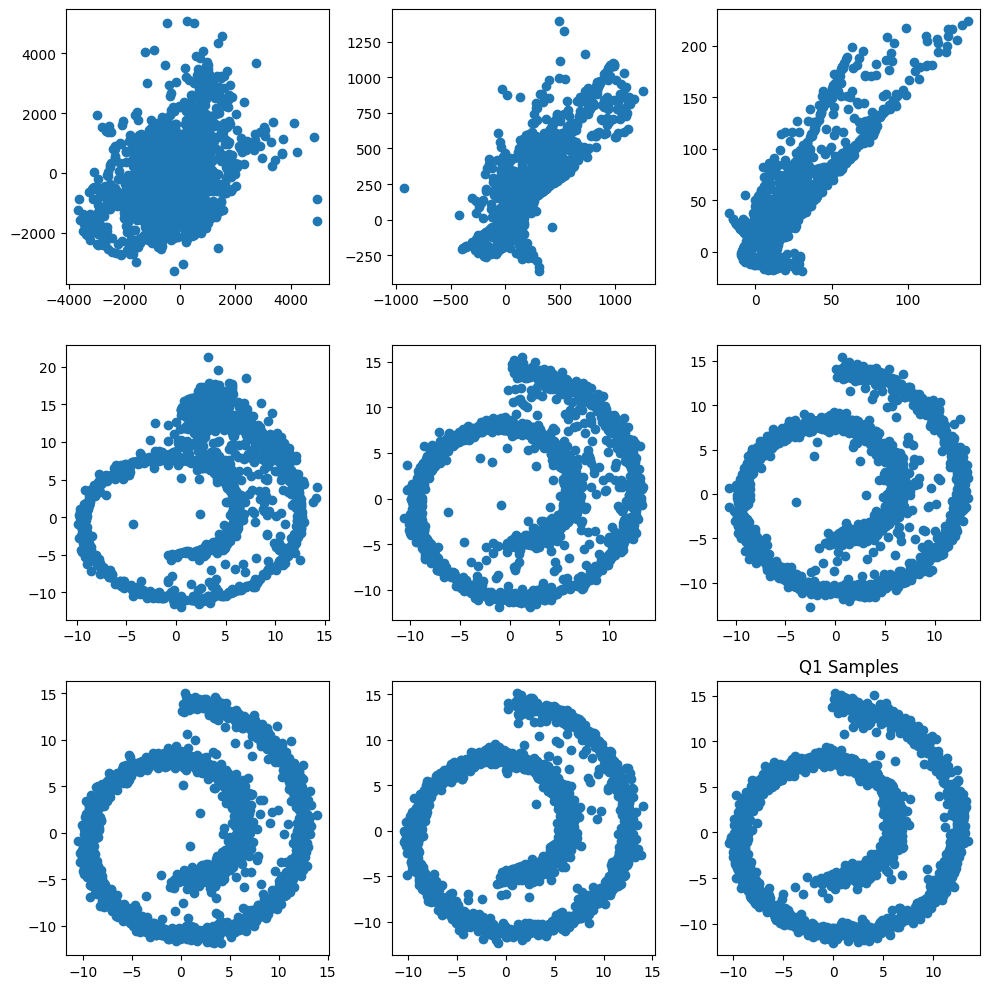

In [ ]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


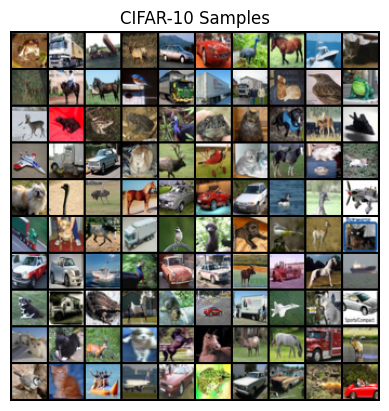

In [ ]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t)
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(t)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [ ]:
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, half, dtype=torch.float32) / half
    ).cuda()
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], axis=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.time_emb_proj = nn.Sequential(
            nn.SiLU(), nn.Linear(temb_channels, out_channels)
        )

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)

        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, temb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h)

        temb = self.time_emb_proj(temb)
        h += temb[:, :, None, None]

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)

        if self.in_channels != self.out_channels:
            x = self.skip(x)
        return x + h


class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super().__init__()
        self.hidden_dims = hidden_dims

        temb_channels = hidden_dims[0] * 4
        self.time_embedding = nn.Sequential(
            nn.Linear(hidden_dims[0], temb_channels),
            nn.SiLU(),
            nn.Linear(temb_channels, temb_channels),
        )

        prev_ch = hidden_dims[0]
        down_block_chans = [prev_ch]
        down_blocks = nn.ModuleList([nn.Conv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1)])
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                down_blocks.append(ResidualBlock(prev_ch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                down_block_chans.append(prev_ch)
            if i != len(hidden_dims) - 1:
                down_blocks.append(Downsample(prev_ch))
                down_block_chans.append(prev_ch)
        self.down_blocks = down_blocks

        self.middle_res1 = ResidualBlock(prev_ch, prev_ch, temb_channels)
        self.middle_res2 = ResidualBlock(prev_ch, prev_ch, temb_channels)

        up_blocks = nn.ModuleList([])
        for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(blocks_per_dim + 1):
                dch = down_block_chans.pop()
                up_blocks.append(ResidualBlock(prev_ch + dch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                if i and j == blocks_per_dim:
                    up_blocks.append(Upsample(prev_ch))
        self.up_blocks = up_blocks

        self.out = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=prev_ch),
            nn.SiLU(),
            nn.Conv2d(prev_ch, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        hs = []
        emb = self.time_embedding(timestep_embedding(t, self.hidden_dims[0]))
        h = x
        for module in self.down_blocks:
            if isinstance(module, ResidualBlock):
                h = module(h, emb)
            else:
                h = module(h)
            hs.append(h)
        h = self.middle_res1(h, emb)
        h = self.middle_res2(h, emb)
        for module in self.up_blocks:
            if isinstance(module, ResidualBlock):
                h = torch.cat([h, hs.pop()], dim=1)
                h = module(h, emb)
            else:
                h = module(h)
        h = self.out(h)
        return h

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(np.linspace(0, 9, 10), 2).astype(int)
    """
    train_data = 2 * np.transpose(train_data, (0, 3, 1, 2)) - 1
    train_data = data.TensorDataset(torch.FloatTensor(train_data))
    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)

    test_data = 2 * np.transpose(test_data, (0, 3, 1, 2)) - 1
    test_data = data.TensorDataset(torch.FloatTensor(test_data))
    test_loader = data.DataLoader(train_data, batch_size=256)

    model = UNet(3, [64, 128, 256, 512], 2).cuda()
    model = Diffusion(model, (3, 32, 32))

    total_params = sum([np.prod(p.shape) for p in model.parameters()])
    print(f'Total parameters: {total_params / 1e6:.3f}M')

    train_losses, test_losses = train_epochs(
        model, train_loader, test_loader,
        dict(epochs=60, lr=1e-3, warmup=100, use_cos_decay=True)
    )
    torch.save(model.state_dict(), 'q2_model.pt')

    samples = []
    for num_steps in np.power(np.linspace(0, 9, 10), 2).astype(int):
        s = model.sample(10, num_steps, clip_denoised=True).clamp(-1, 1)
        s = s.movedim(1, -1).cpu().numpy()
        s = s * 0.5 + 0.5
        samples.append(s)
    samples = np.stack(samples, axis=0)
    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified
Total parameters: 55.518M


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Test loss 0.0969, Train loss 0.1932


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Test loss 0.0777, Train loss 0.0851


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Test loss 0.0746, Train loss 0.0755


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Test loss 0.0717, Train loss 0.0712


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Test loss 0.0698, Train loss 0.0701


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Test loss 0.0700, Train loss 0.0694


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Test loss 0.0680, Train loss 0.0676


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Test loss 0.0671, Train loss 0.0674


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Test loss 0.0671, Train loss 0.0672


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Test loss 0.0677, Train loss 0.0669


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Test loss 0.0671, Train loss 0.0671


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Test loss 0.0655, Train loss 0.0659


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Test loss 0.0654, Train loss 0.0666


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Test loss 0.0654, Train loss 0.0650


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Test loss 0.0655, Train loss 0.0657


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Test loss 0.0656, Train loss 0.0642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Test loss 0.0649, Train loss 0.0650


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Test loss 0.0642, Train loss 0.0640


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Test loss 0.0638, Train loss 0.0642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Test loss 0.0646, Train loss 0.0638


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Test loss 0.0644, Train loss 0.0642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Test loss 0.0656, Train loss 0.0647


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Test loss 0.0647, Train loss 0.0645


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Test loss 0.0649, Train loss 0.0642


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Test loss 0.0633, Train loss 0.0647


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Test loss 0.0646, Train loss 0.0631


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Test loss 0.0638, Train loss 0.0630


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Test loss 0.0638, Train loss 0.0633


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Test loss 0.0630, Train loss 0.0632


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Test loss 0.0635, Train loss 0.0629


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Test loss 0.0635, Train loss 0.0629


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Test loss 0.0636, Train loss 0.0632


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Test loss 0.0642, Train loss 0.0627


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Test loss 0.0621, Train loss 0.0612


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Test loss 0.0621, Train loss 0.0626


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Test loss 0.0627, Train loss 0.0622


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Test loss 0.0624, Train loss 0.0632


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Test loss 0.0618, Train loss 0.0621


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Test loss 0.0621, Train loss 0.0618


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Test loss 0.0621, Train loss 0.0626


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Test loss 0.0619, Train loss 0.0625


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Test loss 0.0627, Train loss 0.0620


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Test loss 0.0617, Train loss 0.0617


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Test loss 0.0610, Train loss 0.0616


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Test loss 0.0616, Train loss 0.0614


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Test loss 0.0614, Train loss 0.0615


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Test loss 0.0615, Train loss 0.0621


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Test loss 0.0619, Train loss 0.0613


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Test loss 0.0615, Train loss 0.0619


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Test loss 0.0617, Train loss 0.0608


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Test loss 0.0606, Train loss 0.0617


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Test loss 0.0610, Train loss 0.0610


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Test loss 0.0612, Train loss 0.0611


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Test loss 0.0604, Train loss 0.0613


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Test loss 0.0617, Train loss 0.0618


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Test loss 0.0619, Train loss 0.0609


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Test loss 0.0616, Train loss 0.0611


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Test loss 0.0616, Train loss 0.0612


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Test loss 0.0606, Train loss 0.0610


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Test loss 0.0607, Train loss 0.0615


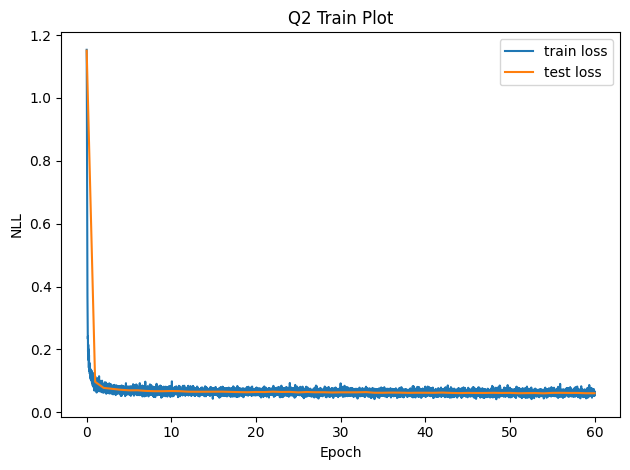

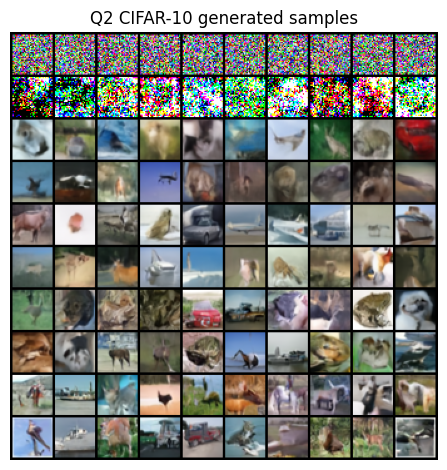

In [ ]:
q2_save_results(q2)

# Question 3: Latent-Space Diffusion on CIFAR-10 with DiT [50pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


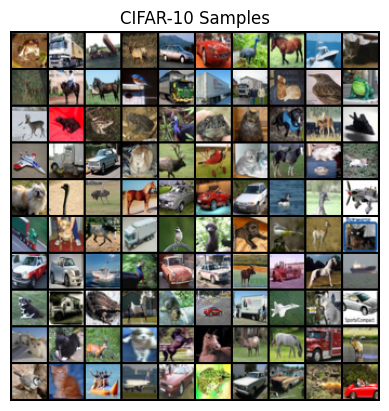

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [ ]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [ ]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
    images = 2 * np.transpose(images, (0, 3, 1, 2)) - 1

    real = images[:50]
    z = vae.encode(real)
    recon = vae.decode(z).cpu().numpy()
    autoencoded_images = np.stack((real, recon), axis=1) * 0.5 + 0.5
    autoencoded_images = np.transpose(autoencoded_images, (0, 1, 3, 4, 2))

    zs = []
    for i in range(0, len(images), 100):
        z = vae.encode(images[i:i + 100])
        zs.append(z)
    zs = torch.cat(zs)
    scale_factor = zs.flatten().std().item()

    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


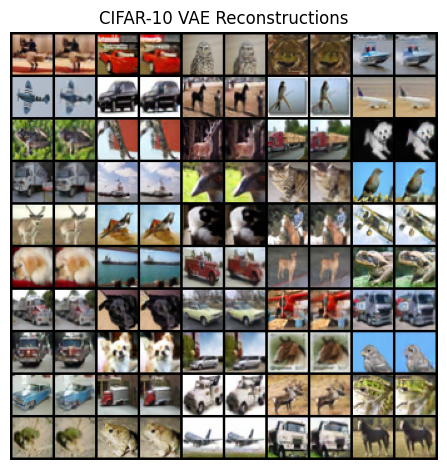

Scale factor: 1.3101


In [ ]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* (Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder

**Remember to save your model parameters after training, as you will need them for part (c)**

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.wq = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wk = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wv = nn.Linear(hidden_size, hidden_size, bias=False)
        self.wo = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        q, k, v = map(lambda x: x.view(*x.shape[:-1], self.num_heads, -1), (q, k, v))
        attn_weights = torch.einsum('bqhd,bkhd->bhqk', q, k) * q.shape[-1] ** -0.5
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_outputs = torch.einsum('bhqk,bkhd->bqhd', attn_weights, v)
        attn_outputs = attn_outputs.reshape(*attn_outputs.shape[:-2], -1)
        return self.wo(attn_outputs)


class MLP(nn.Module):
    def __init__(self, hidden_size, expand=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * expand),
            nn.SiLU(),
            nn.Linear(hidden_size * expand, hidden_size)
        )

    def forward(self, x):
        return self.net(x)

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed


class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.attention = Attention(hidden_size, num_heads)
        self.mlp = MLP(hidden_size)
        self.attention_norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.mlp_norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attention(modulate(self.attention_norm(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.mlp_norm(x), shift_mlp, scale_mlp))
        return x

class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    def __init__(
            self, input_shape, patch_size, hidden_size, num_heads, num_layers,
            num_classes=10, frequency_embedding_size=64, cfg_dropout_prob=0.1
    ):
        super().__init__()
        self.cfg_dropout_prob = cfg_dropout_prob
        self.frequency_embedding_size = frequency_embedding_size
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.patch_size = patch_size

        self.time_embedding = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.label_embedder = nn.Embedding(num_classes + 1, hidden_size)

        C, H, W = input_shape
        n_patches = (H // patch_size) * (W // patch_size)
        self.patchify = nn.Conv2d(C, hidden_size, patch_size, stride=patch_size)
        self.register_buffer('pos_embed', torch.FloatTensor(get_2d_sincos_pos_embed(hidden_size, H // patch_size)))
        self.blocks = nn.ModuleList([DiTBlock(hidden_size, num_heads) for _ in range(num_layers)])
        self.out_layer = FinalLayer(hidden_size, patch_size, C)

    def unpatchify(self, x):
        C, H, W = self.input_shape
        P = self.patch_size
        x = x.view(x.shape[0], H // P, W // P, P, P, C)
        x.shape[0], H // P, P, W // P, P, C
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(x.shape[0], C, H, W)
        return x

    def forward(self, x, y, t):
        # x: BCHW
        x = self.patchify(x).movedim(1, -1)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x + self.pos_embed

        t = self.time_embedding(timestep_embedding(t, self.frequency_embedding_size))
        if self.training:
            drop_ids = torch.rand(y.shape[0], device=y.device) < self.cfg_dropout_prob
            y = torch.where(drop_ids, self.num_classes, y)
        y = self.label_embedder(y)
        c = t + y
        for block in self.blocks:
            x = block(x, c)
        x = self.out_layer(x, c)
        return self.unpatchify(x)

In [ ]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """
    train_data = 2 * np.transpose(train_data, (0, 3, 1, 2)) - 1
    test_data = 2 * np.transpose(test_data, (0, 3, 1, 2)) - 1
    train_data = data.TensorDataset(torch.FloatTensor(train_data), torch.LongTensor(train_labels))
    test_data = data.TensorDataset(torch.FloatTensor(test_data), torch.LongTensor(test_labels))
    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = data.DataLoader(train_data, batch_size=256)

    scale_factor = 1.3101
    def encode_fn(x):
        z = vae.encode(x)
        z /= scale_factor
        return z
    def decode_fn(z):
        z *= scale_factor
        x = vae.decode(z)
        return x

    model = DiT((4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12).cuda()
    model = Diffusion(model, (4, 8, 8), encode_fn=encode_fn, decode_fn=decode_fn)

    total_params = sum([np.prod(p.shape) for p in model.parameters()])
    print(f'Total parameters: {total_params / 1e6:.3f}M')

    train_losses, test_losses = train_epochs(
        model, train_loader, test_loader,
        dict(epochs=60, lr=1e-3, warmup=100, use_cos_decay=True)
    )
    torch.save(model.state_dict(), 'q3_model.pt')

    labels = torch.arange(10, dtype=torch.long).cuda()
    labels = labels.repeat_interleave(10, dim=0)
    def model_fn(x, t):
        return model.model(x, labels, t)
    samples = model.sample(labels.shape[0], 512, clip_denoised=False, model_fn=model_fn)
    samples = samples.movedim(1, -1).cpu().numpy()
    samples = samples * 0.5 + 0.5
    samples = samples.reshape(10, 10, *samples.shape[1:])
    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified
Total parameters: 57.534M


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Test loss 0.4250, Train loss 0.5138


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Test loss 0.4025, Train loss 0.4112


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Test loss 0.4000, Train loss 0.4032


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Test loss 0.3978, Train loss 0.3955


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Test loss 0.3894, Train loss 0.3905


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Test loss 0.3857, Train loss 0.3863


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Test loss 0.3845, Train loss 0.3841


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Test loss 0.3838, Train loss 0.3844


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Test loss 0.3818, Train loss 0.3810


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Test loss 0.3776, Train loss 0.3788


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Test loss 0.3817, Train loss 0.3782


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Test loss 0.3798, Train loss 0.3772


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Test loss 0.3772, Train loss 0.3765


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Test loss 0.3736, Train loss 0.3749


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Test loss 0.3751, Train loss 0.3743


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Test loss 0.3725, Train loss 0.3752


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Test loss 0.3723, Train loss 0.3734


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Test loss 0.3696, Train loss 0.3735


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Test loss 0.3706, Train loss 0.3755


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Test loss 0.3712, Train loss 0.3711


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Test loss 0.3705, Train loss 0.3713


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Test loss 0.3680, Train loss 0.3717


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Test loss 0.3689, Train loss 0.3693


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Test loss 0.3682, Train loss 0.3672


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Test loss 0.3678, Train loss 0.3687


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Test loss 0.3658, Train loss 0.3679


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Test loss 0.3673, Train loss 0.3675


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Test loss 0.3662, Train loss 0.3662


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Test loss 0.3648, Train loss 0.3680


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Test loss 0.3651, Train loss 0.3643


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Test loss 0.3644, Train loss 0.3653


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Test loss 0.3626, Train loss 0.3662


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Test loss 0.3641, Train loss 0.3637


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Test loss 0.3613, Train loss 0.3634


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Test loss 0.3610, Train loss 0.3609


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Test loss 0.3610, Train loss 0.3638


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Test loss 0.3613, Train loss 0.3623


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Test loss 0.3614, Train loss 0.3594


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Test loss 0.3585, Train loss 0.3599


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Test loss 0.3601, Train loss 0.3620


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Test loss 0.3589, Train loss 0.3600


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Test loss 0.3601, Train loss 0.3577


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Test loss 0.3560, Train loss 0.3581


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Test loss 0.3586, Train loss 0.3593


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Test loss 0.3573, Train loss 0.3568


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Test loss 0.3578, Train loss 0.3569


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Test loss 0.3538, Train loss 0.3572


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Test loss 0.3563, Train loss 0.3558


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Test loss 0.3542, Train loss 0.3554


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Test loss 0.3565, Train loss 0.3562


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Test loss 0.3564, Train loss 0.3571


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Test loss 0.3550, Train loss 0.3530


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Test loss 0.3528, Train loss 0.3539


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Test loss 0.3534, Train loss 0.3536


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Test loss 0.3530, Train loss 0.3559


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Test loss 0.3560, Train loss 0.3563


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Test loss 0.3520, Train loss 0.3566


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Test loss 0.3550, Train loss 0.3534


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Test loss 0.3526, Train loss 0.3537


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Test loss 0.3524, Train loss 0.3537


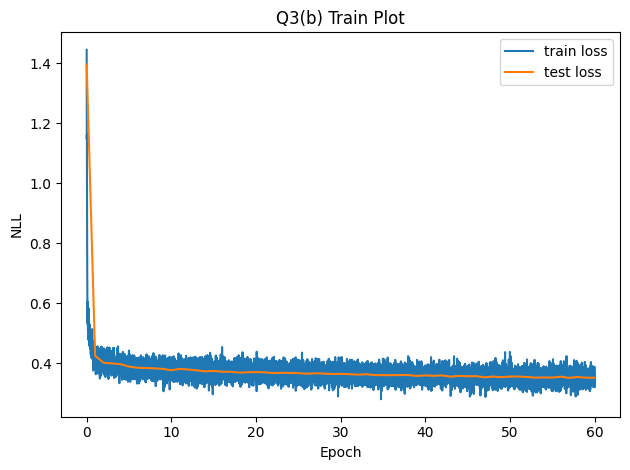

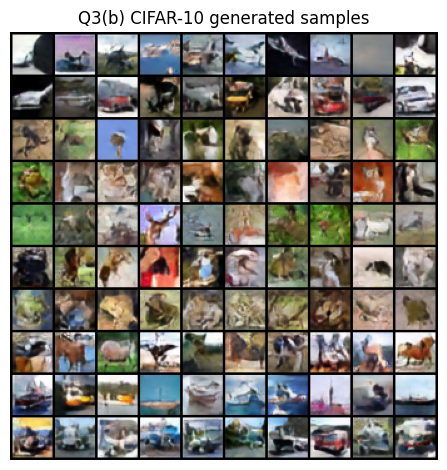

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """
    model = DiT((4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12).cuda()
    model = Diffusion(model, (4, 8, 8), encode_fn=vae.encode, decode_fn=vae.decode)
    model.load_state_dict(torch.load('q3_model.pt'))

    cfg_vals = [1.0, 3.0, 5.0, 7.5]
    samples = []
    labels = torch.arange(10, dtype=torch.long).cuda()
    labels = labels.repeat_interleave(10, dim=0)
    def model_fn(x, t, dropout_cond=False):
        if dropout_cond:
            new_labels = torch.full_like(labels, 10)
        else:
            new_labels = labels
        return model.model(x, new_labels, t)
    for cfg_val in cfg_vals:
        s = model.sample(labels.shape[0], 512, clip_denoised=False, model_fn=model_fn, cfg_val=cfg_val)
        s = s.movedim(1, -1).cpu().numpy()
        s = s * 0.5 + 0.5
        samples.append(s.reshape(10, 10, *s.shape[1:]))
    samples = np.stack(samples, axis=0)
    return samples

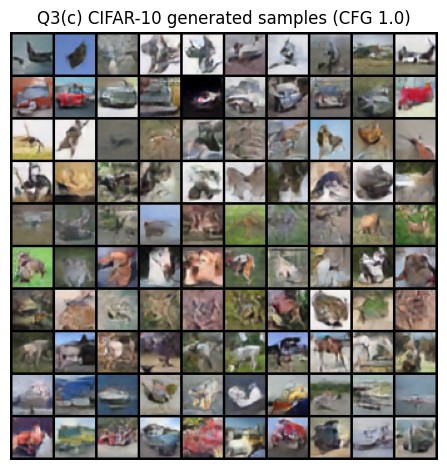

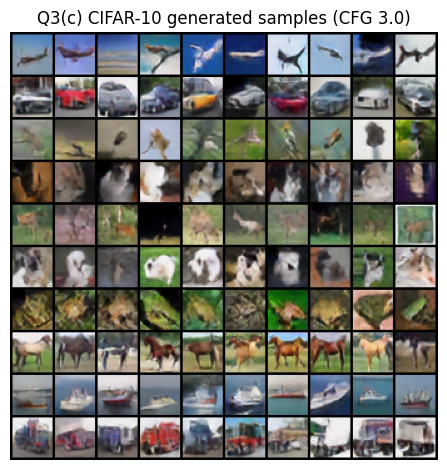

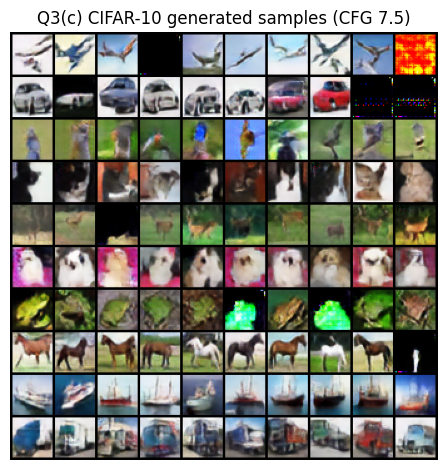

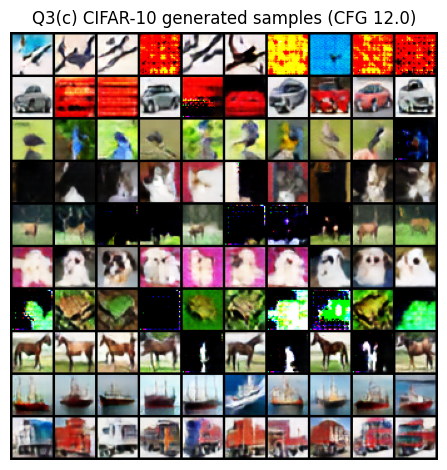

In [ ]:
q3c_save_results(q3_c)